In [1]:
!pip install pycryptodome
!pip install matplotlib

import os
import gc
import time
import torch
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib

run_simulation = False  # Set this to True when you want to run the simulation

# Clear PyTorch's cache
torch.cuda.empty_cache()

# Print GPU information
print("\n" + "="*40)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(device_lib.list_local_devices())
print("="*40 + "\n")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.6 MB/s eta 0:00:00

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11815069345306014929
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 13804306432
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11920228053156947819
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]



In [2]:
!git clone https://github.com/tommysmithgit/VBFLreport
%cd /content/VBFLreport/

Cloning into 'VBFLreport'...
remote: Enumerating objects: 47, done.
remote: Total 47 (delta 0), reused 0 (delta 0), pack-reused 47
Receiving objects: 100% (47/47), 54.85 MiB | 30.93 MiB/s, done.
Resolving deltas: 100% (6/6), done.
/content/VBFLreport


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

# Name for VBFL share folder
vbflshare = '/content/drive/My Drive/VBFL'

Mounted at /content/drive/


In [4]:
# Parameters for the notebook
model_type = "Malicious"
time_limits = ["120", "300"]  # Corresponds to 2 and 5 minutes
iid_values = ["0", "1"]  # Non-IID and IID

Running simulation for 120 seconds, IID: 0
The process ran for 120.39421272277832 seconds.
File Malicious2_iid0.txt successfully copied to shared folder.


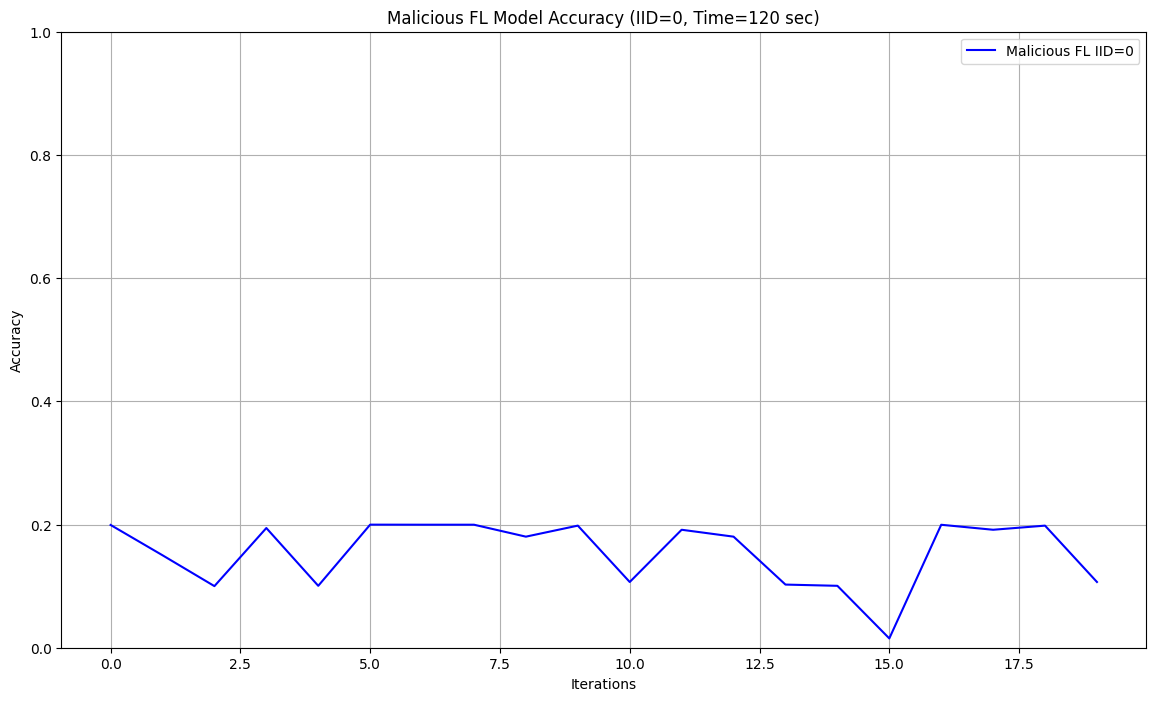

Running simulation for 120 seconds, IID: 1
The process ran for 120.25831031799316 seconds.
File Malicious2_iid1.txt successfully copied to shared folder.


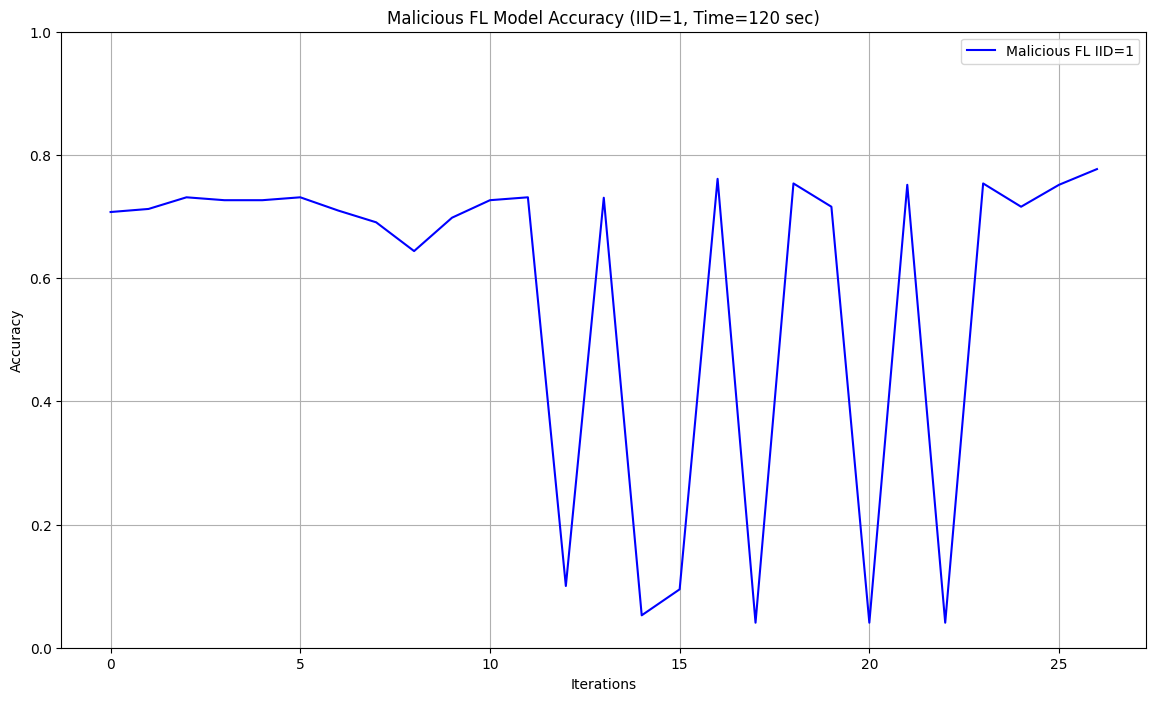

Running simulation for 300 seconds, IID: 0
The process ran for 300.2558240890503 seconds.
File Malicious5_iid0.txt successfully copied to shared folder.


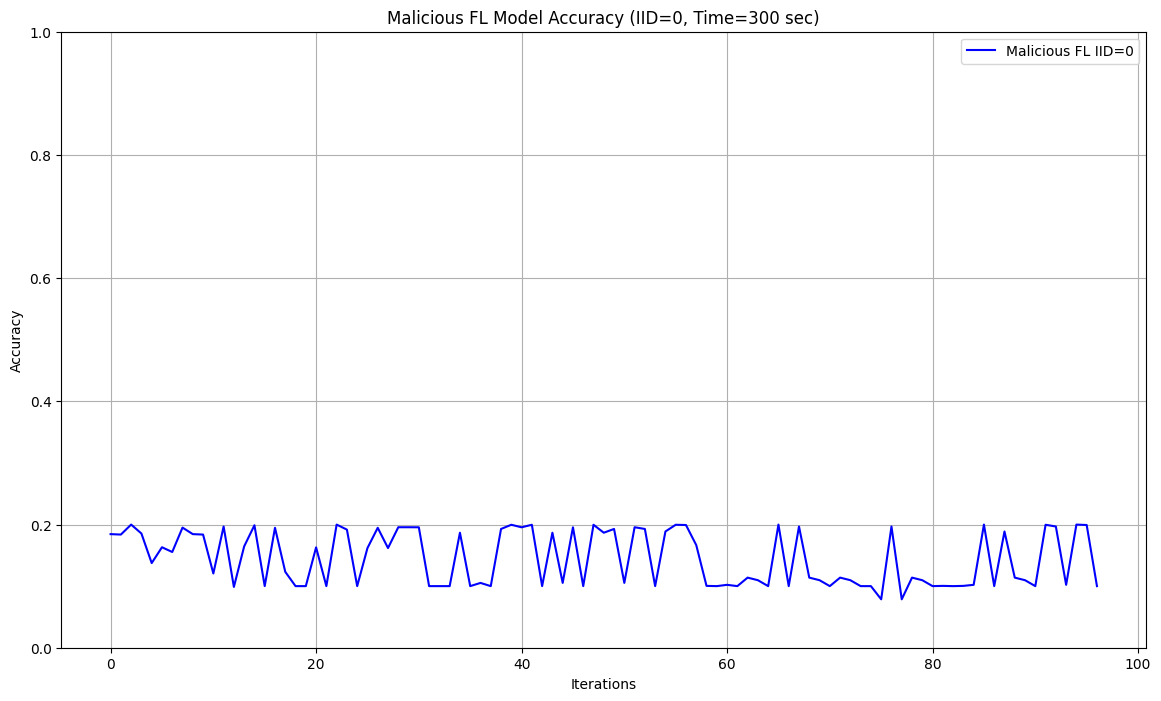

Running simulation for 300 seconds, IID: 1
Traceback (most recent call last):
  File "/content/VBFLreport/main.py", line 809, in <module>
    processing_time = device.process_block(device.return_the_added_block(), log_files_folder_path, conn, conn_cursor)
  File "/content/VBFLreport/Device.py", line 634, in process_block
    precision = TP/(TP + FP)
ZeroDivisionError: division by zero
The process ran for 131.30505466461182 seconds.
File Malicious5_iid1.txt successfully copied to shared folder.


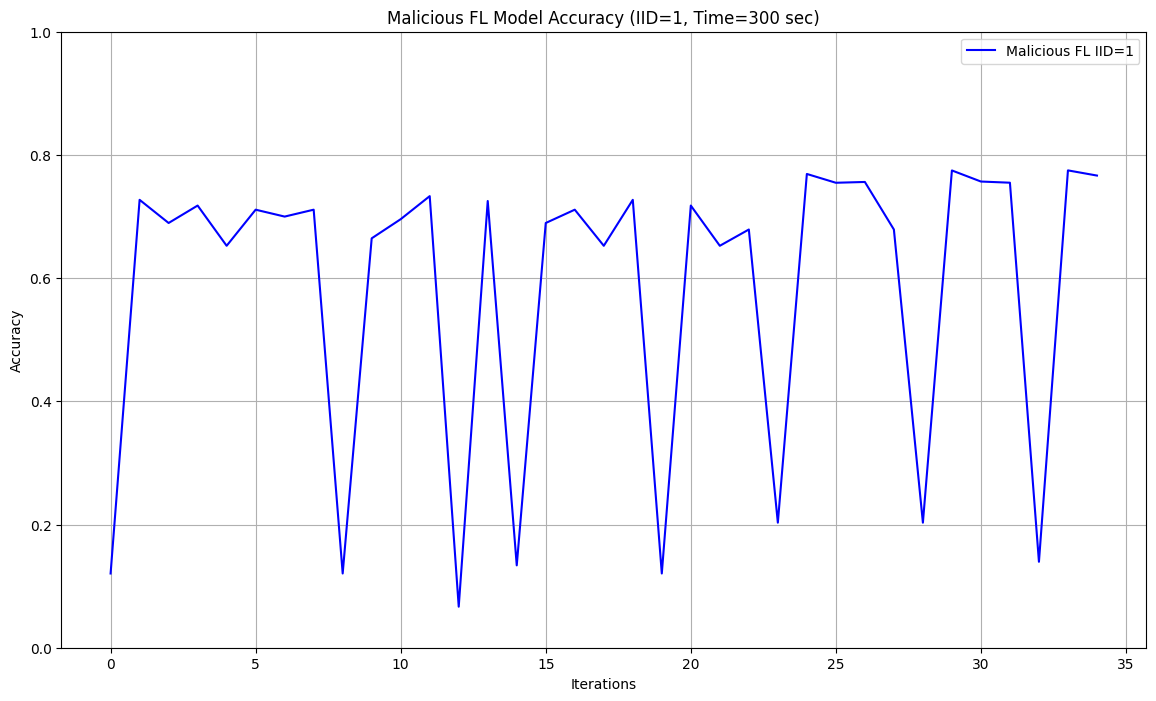

In [5]:
# Function to extract accuracies from the output files
def extract_accuracies(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    accuracies = []
    for line in lines:
        if "model accuracy becomes" in line:
            accuracy_value = float(line.split("model accuracy becomes -")[1].strip())
            accuracies.append(accuracy_value)
    return accuracies

# Loop through each time limit and IID value
for time_limit in time_limits:
    for iid_value in iid_values:
        # Define the output filename
        time_limit_minutes = int(int(time_limit)/60)  # Ensures no decimal point
        output_file = f"{model_type}{time_limit_minutes}_iid{iid_value}.txt"
        print(f"Running simulation for {time_limit} seconds, IID: {iid_value}")

        # Record the start time
        start_time = time.time()

        # Run the VBFL simulation for Malicious Model
        !timeout {time_limit} python main.py -nd 50 -max_ncomm 100 -ha *,*,* -aio 0 -pow 0 -ko 6 -nm 15 -vh 0.05 -cs 0 -B 10 -mn mnist_cnn -iid {iid_value} -lr 0.02 -dtx 1 > {output_file}

        # Record the end time and calculate the duration
        end_time = time.time()
        duration = end_time - start_time
        print(f"The process ran for {duration} seconds.")

        # Copy the output file to the shared Google Drive folder
        !cp {output_file} "{vbflshare}/{output_file}"

        # Check if the file was copied successfully
        if os.path.exists(f"{vbflshare}/{output_file}"):
            print(f"File {output_file} successfully copied to shared folder.")
        else:
            print("Failed to copy file. Please check for errors.")

        # Plot the accuracies for the current model
        accuracies = extract_accuracies(output_file)
        if accuracies:
            plt.figure(figsize=(14, 8))
            plt.plot(accuracies, label=f'{model_type.capitalize()} FL IID={iid_value}', color='Blue')
            plt.title(f'{model_type.capitalize()} FL Model Accuracy (IID={iid_value}, Time={time_limit} sec)')
            plt.xlabel('Iterations')
            plt.ylabel('Accuracy')
            plt.ylim([0, 1])
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print("No accuracies to plot for the current simulation.")

        # Wait a bit before starting the next simulation
        time.sleep(10)
